In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Softmax, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# read in data
df = pd.read_csv("games.csv")

# remove id, rated, increment_code, white_id, white_rating, black_id, black_rating, opening_name, opening_ply
drop_columns = [
    "id", 
    "rated", 
    "increment_code",
    "white_id",
    "white_rating",
    "black_id",
    "black_rating",
    "opening_name",
    "opening_ply",
    "created_at",
    "last_move_at"
]

df.drop(columns=drop_columns, inplace=True)

# filter out rows where "victory_status" is not "resign" or "mate"
df = df[df["victory_status"].isin(["resign", "mate"])]

print("\nData after filtering on victory_status (keeping only 'resign' or 'mate'):")
print(df.head())

print("Number of rows:", len(df))

# turn “moves” string into a list of plies
df['move_list'] = df['moves'].str.split()

# keep only games with at least 16 plies
n = 16
df = df[df['move_list'].map(len) >= n]

# grab exactly first 16 plies
df['first_n'] = df['move_list'].map(lambda L: L[:n])
df['first_n_str'] = df['first_n'].apply(lambda L: ' '.join(L))

# turn those into integer sequences + pad
# fit on n-ply snippets
tok = Tokenizer(oov_token='<OOV>')
tok.fit_on_texts(df['first_n_str'])

# convert to sequences of ints
seqs = tok.texts_to_sequences(df['first_n_str'])

# pad/truncate each to exactly n positions
X = pad_sequences(seqs,
                  maxlen=n,
                  padding='post',     # pad at end
                  truncating='post')  # truncate at end

# build label y
# map white wins -> 1, black wins -> 0
df = df[df['winner'].isin(['white','black'])]
y = (df['winner'] == 'white').astype(int).values


Data after filtering on victory_status (keeping only 'resign' or 'mate'):
   turns victory_status winner  \
1     16         resign  black   
2     61           mate  white   
3     61           mate  white   
4     95           mate  white   
6     33         resign  white   

                                               moves opening_eco  
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00  
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20  
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02  
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41  
6  d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...         D00  
Number of rows: 17472


--- Fold 1 ---
Fold 1 — Train Accuracy: 0.7501, Val Accuracy: 0.5668
--- Fold 2 ---
Fold 2 — Train Accuracy: 0.7540, Val Accuracy: 0.5838
--- Fold 3 ---
Fold 3 — Train Accuracy: 0.7590, Val Accuracy: 0.5821
--- Fold 4 ---
Fold 4 — Train Accuracy: 0.7622, Val Accuracy: 0.5839
--- Fold 5 ---
Fold 5 — Train Accuracy: 0.7445, Val Accuracy: 0.5848


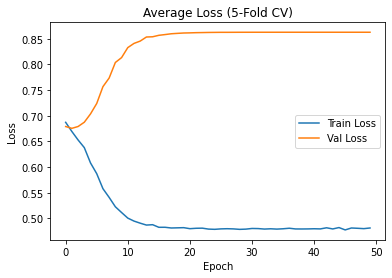

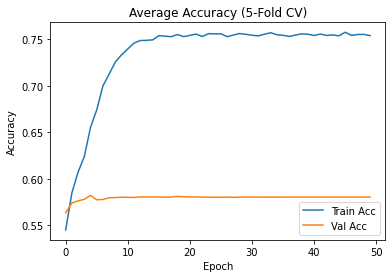

In [3]:
# split data into training and validation sets
# hold out 10% for test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42
)

# from remaining 90%, hold out 1/9 ~= 10% of the *original* for val
# that is 10% of the original data, so (0.10/0.90) ~= 0.111 of X_trainval.
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.1111,      # ~= 10% of the original
    stratify=y_trainval,
    random_state=42
)

# hyperparameters
embed_dim = 128
filters = 64
kernel_size = 3
lstm_units = 128
dropout_rate = 0.3
vocab_size = np.max(X) + 1
seq_length = X.shape[1]
epochs = 50
batch_size = 32

def build_model():
    inputs = Input(shape=(seq_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(
        LSTM(lstm_units, return_sequences=True, 
             dropout=dropout_rate, recurrent_dropout=dropout_rate)
    )(x)
    attn_scores  = Dense(1, activation='tanh')(x)
    attn_weights = Softmax(axis=1)(attn_scores)
    context      = Lambda(lambda t: tf.reduce_sum(t[0] * t[1], axis=1))([attn_weights, x])
    context      = Dropout(dropout_rate)(context)
    outputs      = Dense(1, activation='sigmoid')(context)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f'--- Fold {fold} ---')
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]
    
    tf.keras.backend.clear_session()
    model = build_model()
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[rl],
        verbose=0
    )
    histories.append(history.history)
    
    train_acc = history.history["accuracy"][-1]
    val_acc   = history.history["val_accuracy"][-1]
    print(f'Fold {fold} — Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

# compute average metrics across folds
hist_arr = histories
avg_loss     = np.mean([h['loss']       for h in hist_arr], axis=0)
avg_val_loss = np.mean([h['val_loss']   for h in hist_arr], axis=0)
avg_acc      = np.mean([h['accuracy']   for h in hist_arr], axis=0)
avg_val_acc  = np.mean([h['val_accuracy'] for h in hist_arr], axis=0)

# plot loss
plt.figure()
plt.plot(avg_loss)
plt.plot(avg_val_loss)
plt.title('Average Loss (5-Fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

# plot accuracy
plt.figure()
plt.plot(avg_acc)
plt.plot(avg_val_acc)
plt.title('Average Accuracy (5-Fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

In [4]:
# evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7553
